# DOG DISEASE DETECTION

In [1]:
!pip install tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 24.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing

In [2]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [3]:
import os
import random
import numpy as np
import tensorflow as tf
from pathlib import Path
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Exploration

In [4]:
path_img='/kaggle/input/final-dog-skin-diseases/Final_Skin_Disease_Dataset'
img_directory=os.listdir(path_img)
print("Class Skin Diseases:",img_directory)

Class Skin Diseases: ['earinfection', 'dermatitis', 'healthy', 'skintumors', 'fleas', 'dandruff', 'ringworm']


# Splitting Data

In [5]:
folder_path = '/kaggle/working/'
for i in ["train","validation"]:
    work_path_parent = Path(folder_path+i)
    work_path_parent.mkdir(exist_ok=True)
    for j in img_directory:
        work_path = Path(folder_path+i+"/"+j)
        work_path.mkdir(exist_ok=True)

In [6]:
def split_data(split_size,path_img,img_directory,train_directory,validation_directory):
    files=[]
    for file_dir in img_directory:
        name_image=[]
        for filename in os.listdir(path_img+"/"+file_dir):
            file=path_img+"/"+file_dir+"/"+filename
            if os.path.getsize(file) > 0:
                name_image.append(filename)
            else:
                print(filename + " is zero length, so ignoring.")
        files.append(name_image)
    for index,path_image in enumerate(files):
        train_len=int(len(path_image)*split_size)
        shuffle=random.sample(path_image,len(path_image))
        train_data=path_image[:train_len]
        validation_data=path_image[train_len:]
        for filename in train_data:
            file=path_img+"/"+img_directory[index]+"/"+filename
            destination=train_directory+img_directory[index]+"/"+filename
            copyfile(file,destination)
        for filename in validation_data:
            file=path_img+"/"+img_directory[index]+"/"+filename
            destination=validation_directory+img_directory[index]+"/"+filename
            copyfile(file,destination)

train_directory="/kaggle/working/train/"
validation_directory="/kaggle/working/validation/"
split_size=.75
split_data(split_size,path_img,img_directory,train_directory,validation_directory)

# Dataset

In [8]:
TRAINING_DIR = train_directory
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))
VALIDATION_DIR = validation_directory
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

Found 3959 images belonging to 7 classes.
Found 1321 images belonging to 7 classes.


# Load InceptionV3 Pretrained Model

In [9]:
pre_trained_model =  tf.keras.applications.InceptionV3(input_shape=(150,150,3),
                                                       include_top=False,
                                                       weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


# Freeze Layer

In [10]:
for layer in pre_trained_model.layers:
    layer.trainable = False

# Get Last Layer

In [11]:
last_layer =  pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

# Add Dense Layer & Compile Model

In [12]:
x = layers.Flatten()(last_output)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(7, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

# Train Model

In [13]:
model.fit(train_generator,
                  epochs=100,
                  validation_data=validation_generator)

Epoch 1/100
124/124 [==============================] - 89s 685ms/step - loss: 1.0959 - accuracy: 0.5933 - precision: 0.7827 - recall: 0.4049 - val_loss: 0.7821 - val_accuracy: 0.7192 - val_precision: 0.7840 - val_recall: 0.6321
Epoch 2/100
124/124 [==============================] - 83s 668ms/step - loss: 0.6228 - accuracy: 0.7762 - precision: 0.8456 - recall: 0.7042 - val_loss: 0.4971 - val_accuracy: 0.8304 - val_precision: 0.8741 - val_recall: 0.7676
Epoch 3/100
124/124 [==============================] - 84s 675ms/step - loss: 0.4386 - accuracy: 0.8452 - precision: 0.8815 - recall: 0.7893 - val_loss: 0.4131 - val_accuracy: 0.8509 - val_precision: 0.8863 - val_recall: 0.8259
Epoch 4/100
124/124 [==============================] - 84s 673ms/step - loss: 0.3772 - accuracy: 0.8626 - precision: 0.8928 - recall: 0.8353 - val_loss: 0.2909 - val_accuracy: 0.9031 - val_precision: 0.9213 - val_recall: 0.8690
Epoch 5/100
124/124 [==============================] - 90s 728ms/step - loss: 0.3060 - a

# Evaluation Model

In [14]:
evaluate_model=model.evaluate(validation_generator)

42/42 [==============================] - 14s 336ms/step - loss: 0.1358 - accuracy: 0.9720 - precision: 0.9734 - recall: 0.9705


# Test Model

In [15]:
class_map = train_generator.class_indices
classes_disease = []
for key in class_map.keys():
    classes_disease.append(key)
print(classes_disease)

['dandruff', 'dermatitis', 'earinfection', 'fleas', 'healthy', 'ringworm', 'skintumors']


1/1 [==============================] - 1s 921ms/step


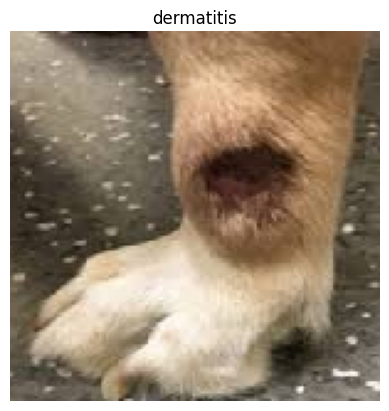

1/1 [==============================] - 0s 40ms/step


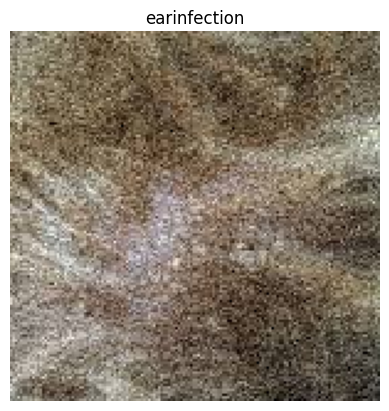

1/1 [==============================] - 0s 40ms/step


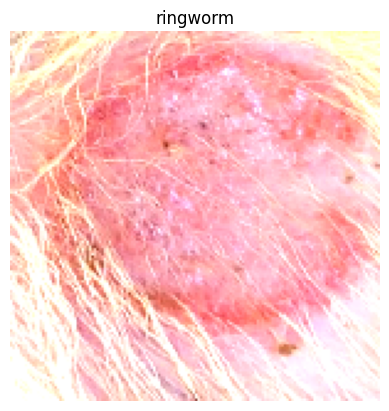

1/1 [==============================] - 0s 42ms/step


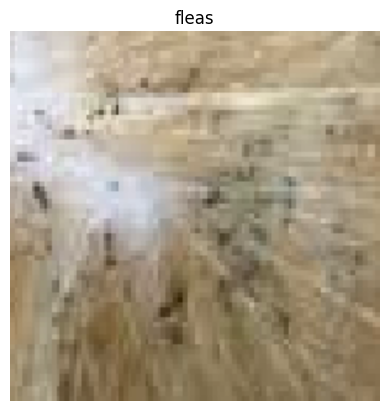

1/1 [==============================] - 0s 40ms/step


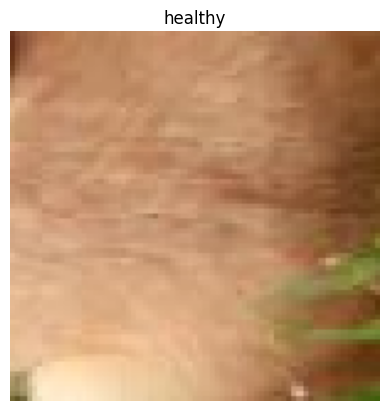

1/1 [==============================] - 0s 44ms/step


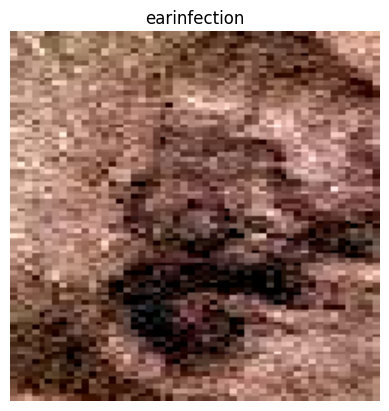

1/1 [==============================] - 0s 40ms/step


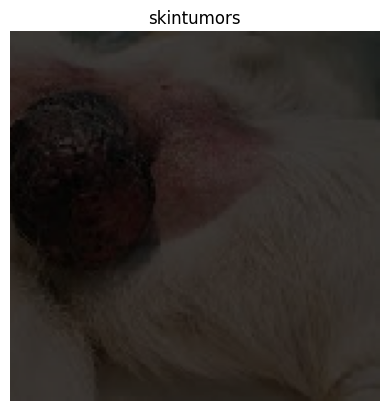

In [16]:
for i in os.listdir('/kaggle/working/validation'):
    for j in os.listdir('/kaggle/working/validation/'+i):
        path='/kaggle/working/validation/'+i+'/'+j
        img = tf.keras.utils.load_img(path, target_size=(150, 150))
        x = tf.keras.utils.img_to_array(img)
        x /= 255
        x = np.expand_dims(x, axis=0)
        image_tensor = np.vstack([x])
        classes = model.predict(image_tensor)
        predicted_class=classes_disease[np.argmax(classes[0])]
        plt.figure()
        plt.imshow(img)
        plt.title(predicted_class)
        plt.axis('off')
        plt.show()
        break

# Save Model and Convert Model To TFJS

In [17]:
model.save("model_saved.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# tf.keras.models.save_model(
#     model, "/kaggle/working/")

In [19]:
saved_model_path = Path('/kaggle/working/'+"saved_model")
saved_model_path.mkdir(exist_ok=True)
tf.saved_model.save(model, "/kaggle/working/saved_model")

In [20]:
!pip install tensorflowjs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 23.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2

In [21]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /kaggle/working/saved_model \
    /kaggle/working/tfjs

2024-06-19 05:20:37.430211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 05:20:37.430324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 05:20:37.431727: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
